In [89]:
conda install shap

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression

from sklearn import datasets, linear_model
from scipy import linalg
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy import stats as st
# Использование статистического API
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap

### 1. Исследование данных

In [3]:
df = pd.read_csv('./datasets/automobile.csv')
df.head()

,Price,Make,Location,Age,Odometer,FuelType,Transmission,OwnerType,Mileage,EngineCC,PowerBhp
0,1.75,marutiwagonr,Mumbai,10,72000,CNG,Manual,First,26.6,998,58.16
1,12.50,hyundaicreta,Pune,5,41000,Diesel,Manual,First,19.67,1582,126.2
2,4.50,hondajazz,Chennai,9,46000,Petrol,Manual,First,18.2,1199,88.7
3,6.00,marutiertiga,Chennai,8,87000,Diesel,Manual,First,20.77,1248,88.76
4,17.74,audia4,Coimbatore,7,40670,Diesel,Automatic,Second,15.2,1968,140.8


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         6019 non-null   float64
 1   Make          6019 non-null   object 
 2   Location      6019 non-null   object 
 3   Age           6019 non-null   int64  
 4   Odometer      6019 non-null   int64  
 5   FuelType      6019 non-null   object 
 6   Transmission  6019 non-null   object 
 7   OwnerType     6019 non-null   object 
 8   Mileage       6019 non-null   object 
 9   EngineCC      6019 non-null   object 
 10  PowerBhp      6019 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 517.4+ KB


In [5]:
for col,colNew in zip(['Mileage', 'EngineCC', 'PowerBhp'],['mileage', 'engineCC', 'powerBhp']):
    df[col] = df[col].replace('+AC0-1',None)
    df[colNew] = df[col].astype('float')

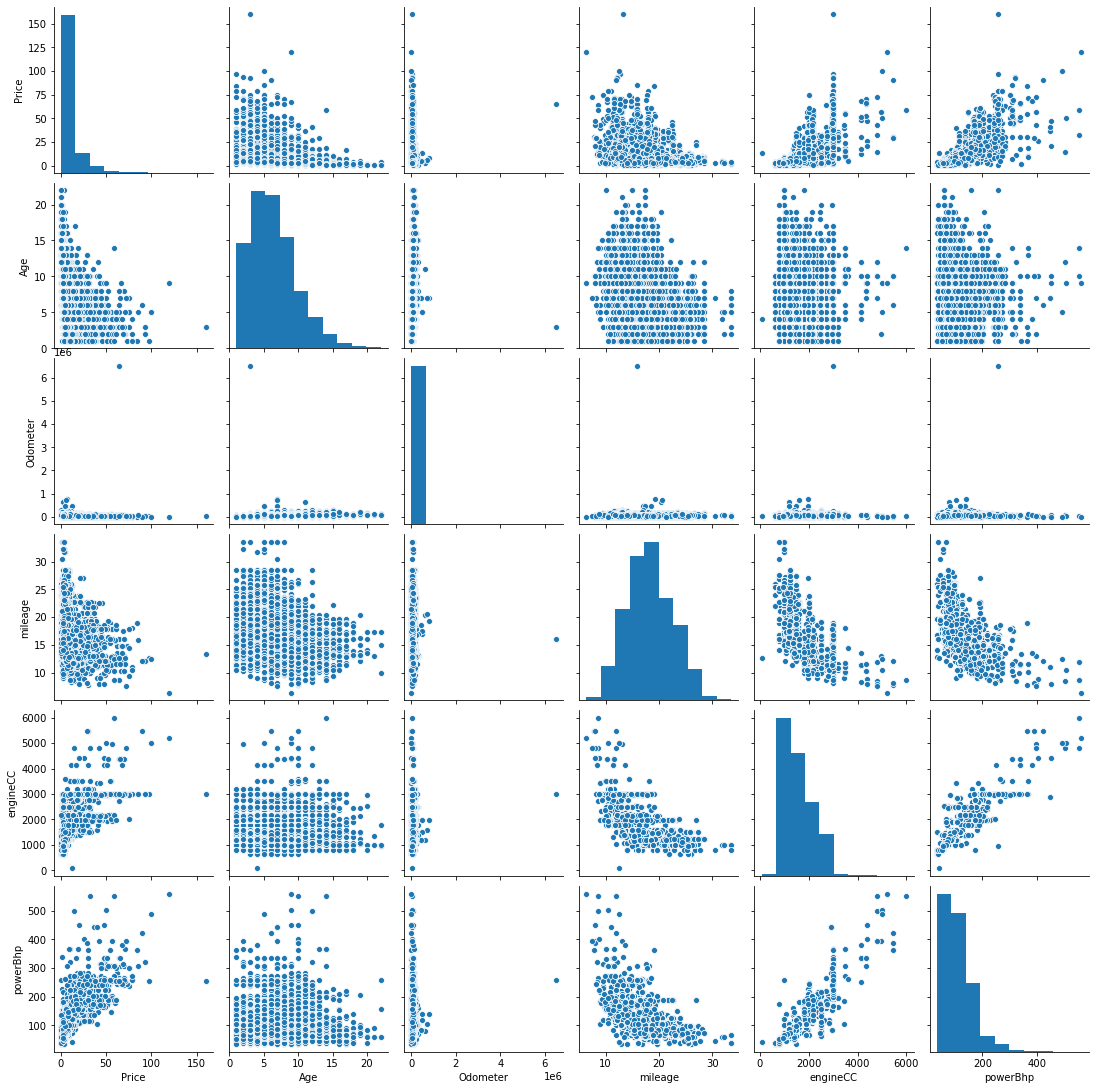

In [6]:
sns.pairplot(df[['Price','Age','Odometer','mileage', 'engineCC', 'powerBhp']])

In [7]:
corrl = (df[['Price','Age','Odometer','mileage','engineCC','powerBhp']]).corr()
corrl.style.background_gradient(cmap='coolwarm')

,Price,Age,Odometer,mileage,engineCC,powerBhp
Price,1.000000,-0.305327,-0.011493,-0.334989,0.659230,0.771140
Age,-0.305327,1.000000,0.173048,-0.295045,0.050181,-0.028722
Odometer,-0.011493,0.173048,1.000000,-0.065223,0.090721,0.031543
mileage,-0.334989,-0.295045,-0.065223,1.000000,-0.641136,-0.545009
engineCC,0.659230,0.050181,0.090721,-0.641136,1.000000,0.863728
powerBhp,0.771140,-0.028722,0.031543,-0.545009,0.863728,1.000000


In [8]:
np.where((df[['Price','Age','Odometer','mileage','engineCC','powerBhp']]).
corr()>0.6,'Yes','No')

array([['Yes', 'No', 'No', 'No', 'Yes', 'Yes'],
       ['No', 'Yes', 'No', 'No', 'No', 'No'],
       ['No', 'No', 'Yes', 'No', 'No', 'No'],
       ['No', 'No', 'No', 'Yes', 'No', 'No'],
       ['Yes', 'No', 'No', 'No', 'Yes', 'Yes'],
       ['Yes', 'No', 'No', 'No', 'Yes', 'Yes']], dtype='<U3')

Power BHP is highly positively correlated with the Price\
EngineCC is also highly correlated with the Price\
Power BHP is also highly correlated with the EngineCC

In [9]:
#create dummy vars
Location_dummy = pd.get_dummies(df.Location,prefix='Location',drop_first=True)
FuelType_dummy = pd.get_dummies(df.FuelType,prefix='FuelType',drop_first=True)
Transmission_dummy = pd.get_dummies(df.Transmission,prefix='Transmission',drop_first=True)
OwnerType_dummy = pd.get_dummies(df.OwnerType,prefix='OwnerType',drop_first=True)
combine_all_dummy = pd.concat([df,Location_dummy,FuelType_dummy,Transmission_dummy, OwnerType_dummy],axis=1)
print(combine_all_dummy.columns)
combine_all_dummy.head()

Index(['Price', 'Make', 'Location', 'Age', 'Odometer', 'FuelType',
       'Transmission', 'OwnerType', 'Mileage', 'EngineCC', 'PowerBhp',
       'mileage', 'engineCC', 'powerBhp', 'Location_Bangalore',
       'Location_Chennai', 'Location_Coimbatore', 'Location_Delhi',
       'Location_Hyderabad', 'Location_Jaipur', 'Location_Kochi',
       'Location_Kolkata', 'Location_Mumbai', 'Location_Pune',
       'FuelType_Diesel', 'FuelType_Electric', 'FuelType_LPG',
       'FuelType_Petrol', 'Transmission_Manual',
       'OwnerType_Fourth +ACY- Above', 'OwnerType_Second', 'OwnerType_Third'],
      dtype='object')


,Price,Make,Location,Age,Odometer,FuelType,Transmission,OwnerType,Mileage,EngineCC,...,Location_Mumbai,Location_Pune,FuelType_Diesel,FuelType_Electric,FuelType_LPG,FuelType_Petrol,Transmission_Manual,OwnerType_Fourth +ACY- Above,OwnerType_Second,OwnerType_Third
0,1.75,marutiwagonr,Mumbai,10,72000,CNG,Manual,First,26.6,998,...,1,0,0,0,0,0,1,0,0,0
1,12.50,hyundaicreta,Pune,5,41000,Diesel,Manual,First,19.67,1582,...,0,1,1,0,0,0,1,0,0,0
2,4.50,hondajazz,Chennai,9,46000,Petrol,Manual,First,18.2,1199,...,0,0,0,0,0,1,1,0,0,0
3,6.00,marutiertiga,Chennai,8,87000,Diesel,Manual,First,20.77,1248,...,0,0,1,0,0,0,1,0,0,0
4,17.74,audia4,Coimbatore,7,40670,Diesel,Automatic,Second,15.2,1968,...,0,0,1,0,0,0,0,0,1,0


In [10]:
#clean usefull cols
clean_df = combine_all_dummy.drop(columns=['Make','Location','FuelType','Transmission','OwnerType', 'Mileage', 'EngineCC','PowerBhp'])

In [11]:
clean_df.columns

Index(['Price', 'Age', 'Odometer', 'mileage', 'engineCC', 'powerBhp',
       'Location_Bangalore', 'Location_Chennai', 'Location_Coimbatore',
       'Location_Delhi', 'Location_Hyderabad', 'Location_Jaipur',
       'Location_Kochi', 'Location_Kolkata', 'Location_Mumbai',
       'Location_Pune', 'FuelType_Diesel', 'FuelType_Electric', 'FuelType_LPG',
       'FuelType_Petrol', 'Transmission_Manual',
       'OwnerType_Fourth +ACY- Above', 'OwnerType_Second', 'OwnerType_Third'],
      dtype='object')

Before proceeding to creating a Linear Regression Model, we need to verify the assumptions of LR\
исслодовать a linear relationship\
All variables follow a normal distribution\
There is very little or no multicollinearity\
There is little or no autocorrelation\
Data is homoscedastic

Прежде чем приступить к созданию модели линейной регрессии, нам необходимо проверить предположения LR\
исследуется линейная зависимость\
Все переменные имеют нормальное распределение\
Мультиколлинеарность очень мала или отсутствует\
Автокорреляция незначительна или отсутствует\
Данные гомоскедастичны

investigating a linear relationship\
as seen before from corr matrix  Power BHP is highly correlated with Price and EngineCC is significant correlated

исследование линейной взаимосвязи\
из матрицы corr видно, Power BHP сильно коррелирует с ценой, а EngineCC имеет м ней значительную корреляцию, однакко не выше 0.9 в абсолютном выражении

распределение

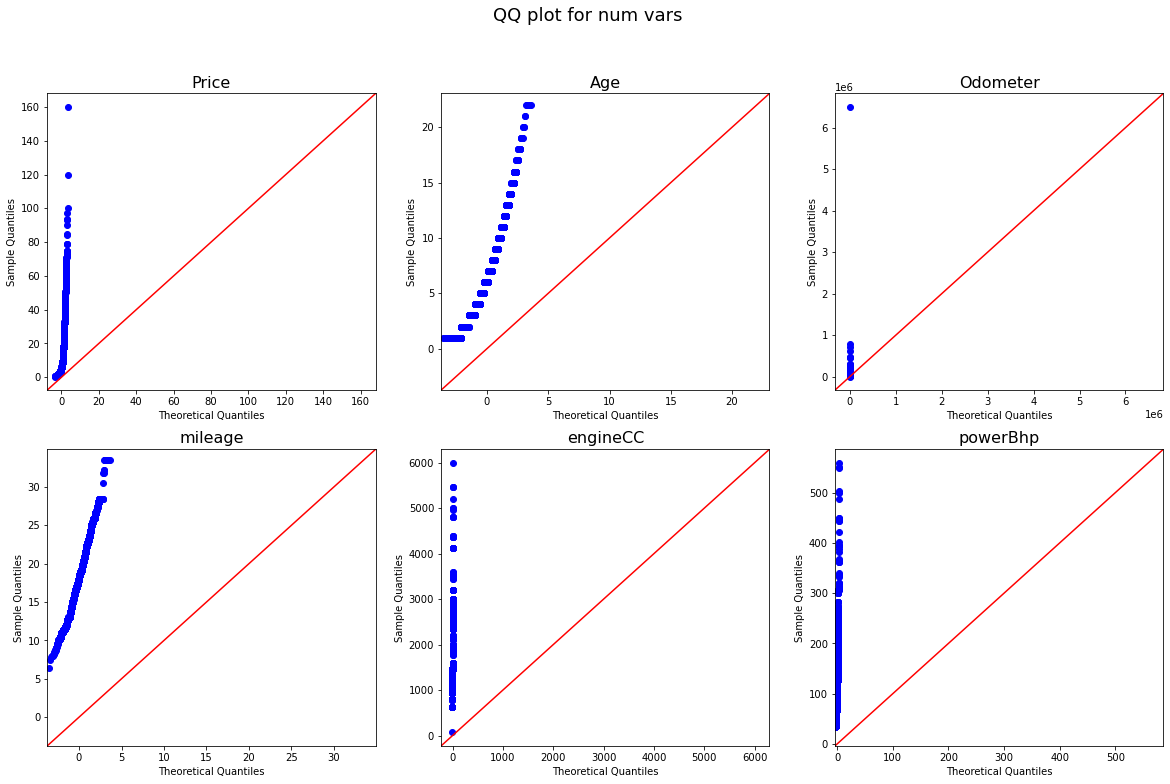

In [12]:
fig, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3,figsize=(20,12))
fig.suptitle('QQ plot for num vars',fontsize=18)

for col,axes  in zip(['Price','Age','Odometer','mileage','engineCC','powerBhp'],[ax1, ax2, ax3,ax4,ax5,ax6]):
    sm.qqplot(clean_df[col], line ='45', ax = axes)
    axes.set_title(col,fontsize=16)
plt.show()

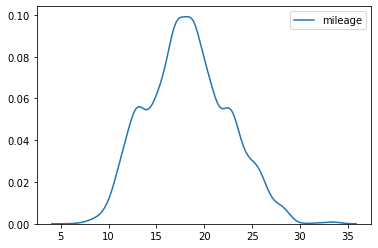

In [91]:
sns.kdeplot(clean_df.mileage)

In [13]:
#Тест Колмогорова Смирнова на нормальность
alpha = 0.05
for col  in ['Price','Age','Odometer','mileage','engineCC','powerBhp']:
    D, pval = stats.kstest(clean_df[col],'norm')
    if pval < alpha:
        print(f'{col} is not normal')
    else:
        print(f'{col} is normal')

Price is not normal
Age is not normal
Odometer is not normal
mileage is not normal
engineCC is not normal
powerBhp is not normal


распределения не близки к нормальному, millage выглядит приблизительно нормлаьным

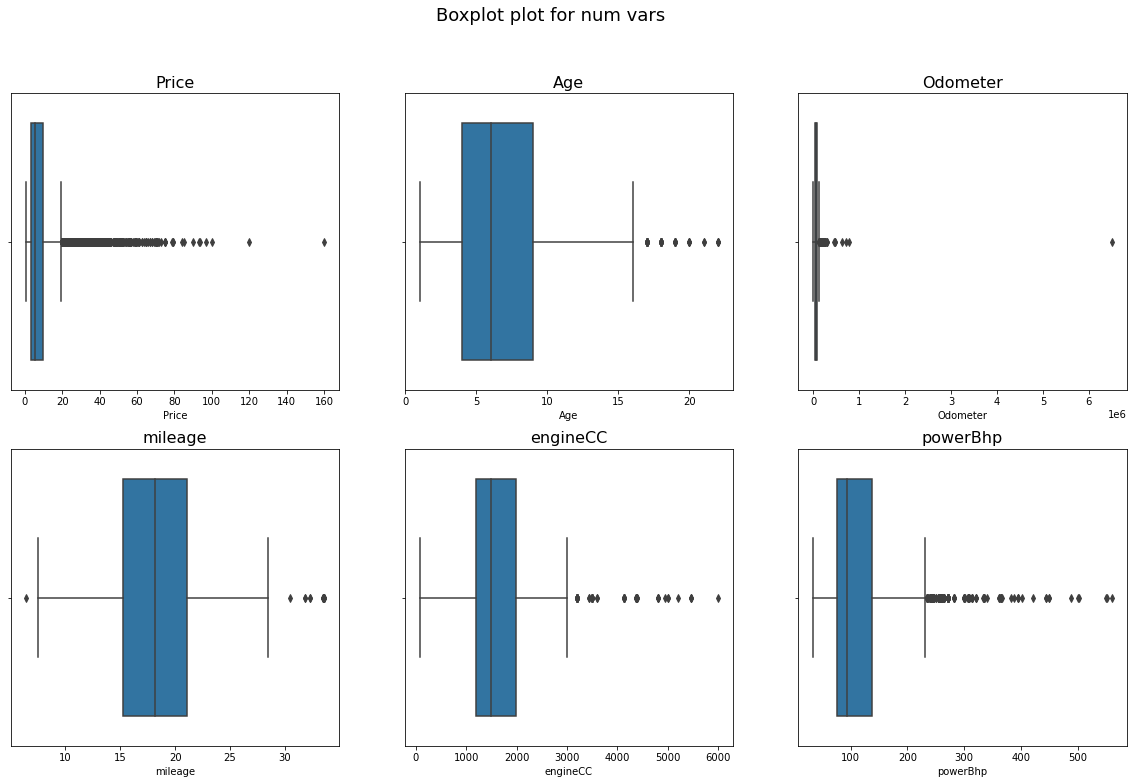

In [14]:
fig, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3,figsize=(20,12))
fig.suptitle('Boxplot plot for num vars',fontsize=18)
for col,axes  in zip(['Price','Age','Odometer','mileage','engineCC','powerBhp'],[ax1, ax2, ax3,ax4,ax5,ax6]):
    sns.boxplot(clean_df[col], ax = axes)
    axes.set_title(col,fontsize=16)
plt.show()

In [15]:
# Q3 + 1.5*IQR
def find_outliers(x):
    IQR = x.describe()[6]-x.describe()[4] #Q3-Q1
    UCL = x.describe()[6] + 1.5*IQR # Q3+1.5*IQR
    LCL = x.describe()[4] - 1.5*IQR #Q1-1.5*IQR
    H_values = x[x > UCL] # outliers on the higher side
    L_values = x[x < LCL] #outliers on the lower side
    return(len(H_values),len(L_values)) #number of outliers

In [16]:
for col  in ['Price','Age','Odometer','mileage','engineCC','powerBhp']:
    ots = find_outliers(clean_df[col])
    print(f'{col} outliers on the higher side: {ots[0]},  outliers on the lower side: {ots[1]}')

Price outliers on the higher side: 718,  outliers on the lower side: 0
Age outliers on the higher side: 50,  outliers on the lower side: 0
Odometer outliers on the higher side: 202,  outliers on the lower side: 0
mileage outliers on the higher side: 14,  outliers on the lower side: 1
engineCC outliers on the higher side: 61,  outliers on the lower side: 0
powerBhp outliers on the higher side: 239,  outliers on the lower side: 0


В зависимых переменных много выбросов, нужно обработать их.
есть несколько вариантов для обработки выбросов:
1. Знать о выбросах, считать их реальностью, продолжать моделирование.
2. Удалить выбросы из набора данных, это потере данных, потере информации.
3. Уменьшите пороговое значение выбросов, все, что больше UCL = Q3, и меньше LCL = Q1, мы можем построить хорошую модель, но ей будет не хватать реальности.
4. Замена выбросы средним, средним значением и т.д.


In [17]:
# feats = [col for col in  clean_df.columns if col!='Price']
# data_train, data_test = train_test_split(clean_df,test_size=0.25,random_state=1234)
# XTrain = np.array(data_train[feats])
# YTrain = np.array(data_train['Price'])
# XTest = np.array(data_test[feats])
# YTest = np.array(data_test['Price'])
# XTrain.shape, XTest.shape

### 2. Линейная регрессия

In [18]:
data_train, data_test = train_test_split(clean_df,test_size=0.25,random_state=1234)
XTrain = np.array(data_train.iloc[:,0:(clean_df.shape[1]-1)])
YTrain = np.array(data_train['Price'])
XTest = np.array(data_test.iloc[:,0:(clean_df.shape[1]-1)])
YTest = np.array(data_test['Price'])
XTrain.shape, XTest.shape

((4514, 23), (1505, 23))

In [19]:
#модель множественной линейной регрессии
reg = linear_model.LinearRegression()
reg.fit(XTrain,YTrain) #обучение модели
print('Coefficients: \n', np.round(reg.coef_,4))
print('Intercept: \n', np.round(reg.intercept_,0))
reg.score(XTrain,YTrain) # значение R-квадрат для обученной модели
reg.score(XTest,YTest) # значение R-квадрат для тестового набора

Coefficients: 
 [ 1.  0.  0. -0. -0.  0.  0.  0.  0.  0. -0.  0.  0.  0. -0.  0. -0.  0.
 -0.  0.  0. -0. -0.]
Intercept: 
 0.0


1.0

In [20]:
y = np.array(clean_df['Price'])
xx = np.array(clean_df[['Price', 'Age', 'Odometer', 'mileage', 'engineCC',
'powerBhp',
'Location_Bangalore', 'Location_Chennai', 'Location_Coimbatore',
'Location_Delhi', 'Location_Hyderabad', 'Location_Jaipur',
'Location_Kochi', 'Location_Kolkata', 'Location_Mumbai',
'Location_Pune', 'FuelType_Diesel', 'FuelType_Electric', 'FuelType_LPG',
'FuelType_Petrol', 'Transmission_Manual',
'OwnerType_Fourth +ACY- Above', 'OwnerType_Second', 'OwnerType_Third']])
mod = sm.OLS(y, xx)
results = mod.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.420e+28
Date:                Sun, 19 Mar 2023   Prob (F-statistic):                        0.00
Time:                        17:21:53   Log-Likelihood:                      1.5537e+05
No. Observations:                6019   AIC:                                 -3.107e+05
Df Residuals:                    5995   BIC:                                 -3.105e+05
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [21]:
# Это может указывать на наличие сильной мультиколлинеарности
print('Parameters: ', results.params)
print('R2: ', results.rsquared)
print('Standard errors: ', results.bse)
print('Predicted values: ', results.predict())

Parameters:  [ 1.00000000e+00  2.61265619e-16 -1.35474851e-17  1.24566698e-15
 -1.14374859e-17 -3.46646540e-16 -5.50666283e-16  1.52406299e-15
 -8.91376816e-16  4.42083436e-17  7.83227649e-16  2.05131051e-15
  2.89476559e-15  7.47665818e-16  3.02649615e-15  1.10648253e-15
 -8.25858479e-15 -6.70242941e-15 -1.04274228e-14 -6.90766888e-15
 -1.55105963e-15 -1.74101185e-15 -1.94289029e-16 -1.22981052e-15]
R2:  1.0
Standard errors:  [3.12971242e-15 7.59842664e-15 2.17734290e-19 5.39372560e-15
 7.69346139e-17 9.38063491e-16 1.24744223e-13 1.18285790e-13
 1.13267732e-13 1.14583330e-13 1.11039777e-13 1.21507853e-13
 1.12516804e-13 1.16531496e-13 1.09223139e-13 1.12983588e-13
 1.62415810e-13 1.06501873e-12 4.95583298e-13 1.46537648e-13
 5.75405811e-14 5.01288872e-13 5.66470982e-14 1.49143437e-13]
Predicted values:  [ 1.75 12.5   4.5  ...  2.9   2.65  2.5 ]


**Variance Inflation Factor – VIF**
Высокая степень мультиколлинеарности между различными переменными может быть объяснена
коэффициентом инфляции дисперсии (Variance Inflation Factor – VIF). VIF для
любого предиктора должен быть меньше 10. В любой ситуации он не может
быть больше 10.

VIF (variance inflation factor)  – это коэффициент инфляции дисперсии. Эта
метрика количественно определяет степень мультиколлинеарности, которая существует в  модели. Мультиколлинеарность можно определить как существование высокой корреляции между более чем двумя независимыми переменными. Стандартная индустриальная практика  – следовать правилу VIF < = 10 для выявления мультиколлинеарности в  модели. Связанная с VIF проблема может быть объяснена на примере. Возьмем два признака, X1 и X2. Оба могут быть использованы для прогнозирования зависимой переменной Y.
Коэффициент X1 равен 0.20,и его можно определить так: если X1 изменится на одну единицу, то зависимая переменная, по прогнозу, изменится в 0.20 раза, при этом все остальные переменные в модели остаются неизменными. Когда
X1 и X2 сильно коррелируют, предположение о сохранении всех других переменных неизменными нарушается. Следовательно, мультиколлинеарность должна быть удалена из модели для того, чтобы создать правильную интерпретацию значения коэффициента, соответствующего каждой предикторной переменной.

In [22]:
infl = results.get_influence()
print(infl.summary_frame().filter(regex="dfb"))

        dfb_x1    dfb_x2      dfb_x3    dfb_x4    dfb_x5    dfb_x6    dfb_x7  \
0     0.000000  0.652964 -851.123998  2.146456  6.528969 -5.150795 -0.267632   
1     1.188430  0.083194 -163.018525  0.521792 -0.109038 -0.766920 -0.002499   
2     0.076910  0.012929  -78.460337  0.067231  0.038468 -0.037393 -0.003565   
3     1.247338  0.199184 -302.174298  1.870575 -1.063898 -2.408579  0.074411   
4     0.302747  0.006598 -101.861482  0.107083  0.320341 -0.355979 -0.002375   
...        ...       ...         ...       ...       ...       ...       ...   
6014  0.135970 -0.011481 -102.294923  0.144317 -0.140970 -0.374286 -0.014692   
6015  0.183918  0.023576  -91.320542  0.101246  0.301747 -0.049309 -0.000657   
6016 -0.055708  0.021010 -112.642720  0.078124  0.201258 -0.209608  0.010326   
6017  1.110540 -0.020759  -54.417682  0.284488  0.611825 -0.682864  0.013922   
6018  0.109961 -0.003367   48.008494  0.058589  0.067269 -0.153405  0.000209   

        dfb_x8    dfb_x9   dfb_x10  ...

In [27]:
def calc_vif(X):
    # Расчет VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [28]:
X = clean_df.drop('Price',axis=1)
vif_df = calc_vif(X)
vif_df.sort_values(by='VIF', ascending=False).head()

,variables,VIF
3,engineCC,47.739114
15,FuelType_Diesel,37.931247
4,powerBhp,29.552494
2,mileage,27.715907
18,FuelType_Petrol,26.455456


In [29]:
X = clean_df.drop(['Price','engineCC'],axis=1)
vif_df = calc_vif(X)
vif_df.sort_values(by='VIF', ascending=False).head()

,variables,VIF
14,FuelType_Diesel,31.231801
17,FuelType_Petrol,23.955044
2,mileage,23.103542
3,powerBhp,10.462183
0,Age,7.297420


In [30]:
X = clean_df.drop(['Price','engineCC','FuelType_Diesel'],axis=1)
vif_df = calc_vif(X)
vif_df.sort_values(by='VIF', ascending=False).head()

,variables,VIF
2,mileage,14.916291
3,powerBhp,6.843925
0,Age,6.840977
17,Transmission_Manual,5.612177
12,Location_Mumbai,3.797697


In [31]:
X = clean_df.drop(['Price','engineCC','mileage'],axis=1)
vif_df = calc_vif(X)
vif_df.sort_values(by='VIF', ascending=False).head()

,variables,VIF
13,FuelType_Diesel,20.164122
16,FuelType_Petrol,16.654208
2,powerBhp,9.591883
0,Age,7.077965
17,Transmission_Manual,5.582305


In [32]:
X = clean_df.drop(['Price','engineCC','FuelType_Diesel','mileage','powerBhp'],
axis=1)
vif_df = calc_vif(X)
vif_df.sort_values(by='VIF', ascending=False).head()

,variables,VIF
0,Age,6.322638
15,Transmission_Manual,3.482934
14,FuelType_Petrol,1.997771
6,Location_Hyderabad,1.838072
11,Location_Pune,1.760061


In [33]:
X = clean_df.drop(['Price','engineCC','FuelType_Diesel','mileage'],axis=1)
vif_df = calc_vif(X)
vif_df.sort_values(by='VIF', ascending=False).head()
# VIF менее 10 является приемлемым
# Чем больше VIF, тем менее надежными будут результаты регрессии.
# В целом VIF выше 10 указывает на высокую корреляцию и является поводом для беспокойства.

,variables,VIF
0,Age,6.834173
2,powerBhp,6.782311
16,Transmission_Manual,4.479880
11,Location_Mumbai,2.797853
7,Location_Hyderabad,2.619884


In [34]:
y = clean_df['Price']
x = clean_df.drop(['Price','engineCC','FuelType_Diesel','mileage'],axis=1)
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.25,random_state=1234)
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape
new_model = LinearRegression()
new_model.fit(xtrain,ytrain)
print(new_model.score(xtrain,ytrain))
print(new_model.score(xtest,ytest))

0.7000714797069869
0.6902967954209107


In [35]:
resultsDF = pd.DataFrame()
resultsDF['Variables'] = pd.Series(xtrain.columns)
resultsDF['coefficients'] = pd.Series(np.round(new_model.coef_,2))
resultsDF.sort_values(by='coefficients',ascending=False)

,Variables,coefficients
13,FuelType_Electric,9.02
17,OwnerType_Fourth +ACY- Above,4.70
5,Location_Coimbatore,2.35
3,Location_Bangalore,1.96
7,Location_Hyderabad,1.92
19,OwnerType_Third,1.66
14,FuelType_LPG,1.50
4,Location_Chennai,1.05
8,Location_Jaipur,0.65
12,Location_Pune,0.21


In [36]:
# Значение R2 может увеличиваться по мере добавления в модель избыточных переменных, но скорректированный R2 останется 
# неизменным. Он будет увеличиваться только в том случае, если признак вносит какой-либо вклад в общую объяснимость модели.
def AdjustedRSquare(model,X,Y):
    """Скорректированный R2"""
    YHat = model.predict(X)
    n,k = X.shape
    sse = np.sum(np.square(YHat-Y),axis=0) #sum of suare error
    sst = np.sum(np.square(Y-np.mean(Y)),axis=0) # sum of square total
    R2 = 1- sse/sst #объяснение суммы квадратов
    adjR2 = R2-(1-R2)*(float(k)/(n-k-1))
    return adjR2, R2

In [37]:
def ReturnPValue(model,X,Y):
    YHat = model.predict(X)
    n,k = X.shape
    sse = np.sum(np.square(YHat-Y),axis=0)
    x = np.hstack((np.ones((n,1)),np.matrix(X)))
    df = float(n-k-1)
    sampleVar = sse/df
    sampleVarianceX = x.T*x
    covarianceMatrix = linalg.sqrtm(sampleVar*sampleVarianceX.I)
    se = covarianceMatrix.diagonal()[1:]
    betasTstat = np.zeros(len(se))
    for i in range(len(se)):
        betasTstat[i] = model.coef_[i]/se[i]
    betasPvalue = 1- stats.t.cdf(abs(betasTstat),df)
    return betasPvalue


In [38]:
#Значения коэффициентов с соответствующими вероятностями
resultsDF['p_value'] = pd.Series(np.round(ReturnPValue(new_model,xtrain,ytrain),2))
resultsDF.sort_values(by='coefficients',ascending=False)

,Variables,coefficients,p_value
13,FuelType_Electric,9.02,0.02
17,OwnerType_Fourth +ACY- Above,4.70,0.03
5,Location_Coimbatore,2.35,0.00
3,Location_Bangalore,1.96,0.00
7,Location_Hyderabad,1.92,0.00
19,OwnerType_Third,1.66,0.01
14,FuelType_LPG,1.50,0.29
4,Location_Chennai,1.05,0.01
8,Location_Jaipur,0.65,0.08
12,Location_Pune,0.21,0.31


Если для какого-либо предиктора значение p меньше 0.05, то предиктор является значимым, в противном случае – нет. Если значение p больше 0.05, то значение коэффициента β будет близким к нулю. В этой модели шесть переменных имеют p больше 0.05. Любой предиктор со значением p более 0.05 может быть удален из модели итерационным способом.

In [39]:
resultsDF.sort_values(by='p_value',ascending=False)

,Variables,coefficients,p_value
9,Location_Kochi,-0.06,0.44
6,Location_Delhi,-0.12,0.38
12,Location_Pune,0.21,0.31
14,FuelType_LPG,1.50,0.29
8,Location_Jaipur,0.65,0.08
11,Location_Mumbai,-0.60,0.06
1,Odometer,0.00,0.04
17,OwnerType_Fourth +ACY- Above,4.70,0.03
18,OwnerType_Second,-0.53,0.02
13,FuelType_Electric,9.02,0.02


**Интерпритация** 
Увеличение возраста автомобиля на один год приводит к предполагаемому снижению цен на автомобили на  0.911 единицы. Если предположить, что цена выражена  в тысячах долларов, то снижение цены автомобиля составит 911.00 долл. с каждым годом эксплуатации при  сохранении всех остальных характеристик постоянными

In [40]:
reg.adjR2, reg.R2 = AdjustedRSquare(new_model,xtrain,ytrain)
print (reg.adjR2, reg.R2)

0.6987363872507527 0.7000714797069869


In [41]:
reg.adjR2, reg.R2 = AdjustedRSquare(new_model,xtest,ytest)
print (reg.adjR2, reg.R2)

0.686122897785074 0.6902967954209107


In [46]:
def ErrorMetric(model,X,Y):
    Yhat = model.predict(X)
    MAPE = np.mean(abs(Y-Yhat)/Y)*100
    MSSE = np.mean(np.square(Y-Yhat))
    Error = sns.distplot(Y-Yhat)
    return MAPE, MSSE, Error

(74.52047160094006,
 37.417570616183106,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a0c10b31f0>)

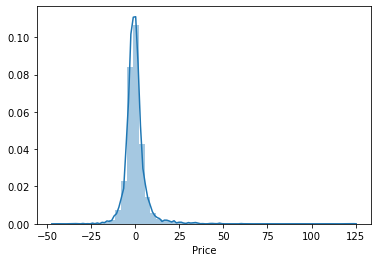

In [47]:
MAPE_train, MSSE_train, Error_train = ErrorMetric(new_model,xtrain,ytrain)
MAPE_train, MSSE_train, Error_train

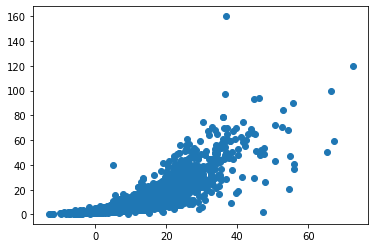

In [48]:
plt.scatter(new_model.predict(xtrain),ytrain)

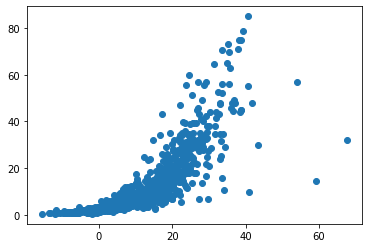

In [49]:
plt.scatter(new_model.predict(xtest),ytest)

In [53]:
y = clean_df['Price']
x = clean_df.drop(['Price','engineCC','FuelType_Diesel','mileage','Location_Kochi','Location_Delhi','Location_Pune','FuelType_LPG'],axis=1)
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.25,random_state=1234)
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape
new_model = LinearRegression()
new_model.fit(xtrain,ytrain)
print(new_model.score(xtrain,ytrain))
print(new_model.score(xtest,ytest))

0.70000423172522
0.6898005338656238


In [51]:
#После удаления сильно мультиколлинеарных переменных и избыточных переменных, имеющих статистическую незначительность, 
#точность модели остается близкой к 70 % на обучающем множестве и 69 % на тестовом множестве.
y = clean_df['Price']
x = clean_df.drop(['Price','engineCC','FuelType_Diesel','mileage','Location_Kochi'],axis=1)
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.25,random_state=1234)
new_model = LinearRegression()
new_model.fit(xtrain,ytrain)
print(new_model.score(xtrain,ytrain))
print(new_model.score(xtest,ytest))

0.7000706125623979
0.6903132829996341


### 3. SHAP для интерпретации модели

**Partial Dependence Plots (графики частичной зависимости или же PDP, PD-графики)** показывают незначительное влияние одного или двух признаков на прогнозируемый результат модели машинного обучения. PDP может показать связь между целью и выбранными признаками с помощью 1D или 2D графиков.

Пунктирная горизонтальная линия показывает ожидаемое значение выхода модели при применении к набору данных, вертикальная пунктирная линия показывает среднее значение возраста. Синяя линия графика частичной зависимости, которая представляет собой среднее значение выхода модели при фиксации возраста на заданном значении, всегда проходит через точку пересечения двух серых линий ожидаемого значения. 

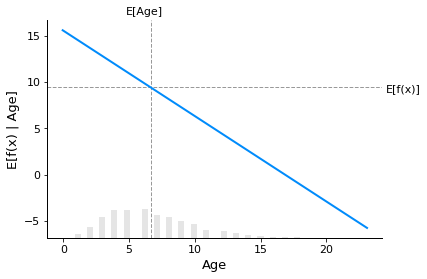

In [54]:
shap.plots.partial_dependence("Age", new_model.predict,xtrain, ice=False,
model_expected_value=True, feature_expected_value=True)

Основная идея, лежащая в основе объяснения модели, основанной на значении Shaple, заключается в использовании распределения результатов теории кооперативных игр для распределения вознаграждения за выход модели f(𝑥) между ее входными характеристиками.
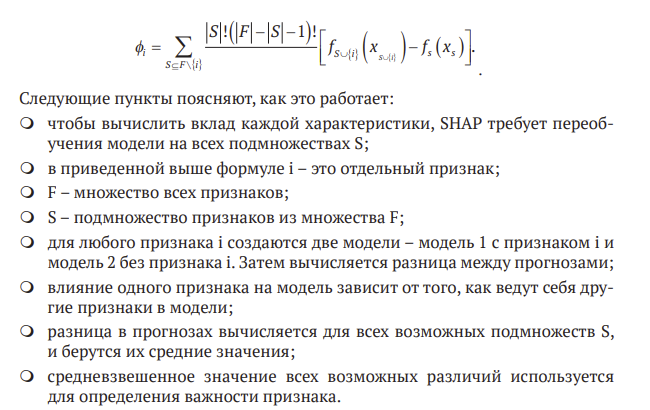

In [55]:
background = shap.maskers.Independent(xtrain, max_samples=2000)
background

In [56]:
xtrain.shape

(4514, 16)

In [57]:
explainer = shap.Explainer(new_model, background)
explainer

In [58]:
shap_values = explainer(xtrain)
shap_values

.values =
array([[ 3.21498712e+00, -4.66764217e-02,  4.88656992e+00, ...,
        -7.06748172e-03,  8.42517661e-02, -1.61673519e-02],
       [-1.39828181e+00,  2.85924841e-03, -3.71560642e+00, ...,
        -7.06748172e-03,  8.42517661e-02, -1.61673519e-02],
       [-1.39828181e+00,  1.17408602e-02, -5.53475519e+00, ...,
        -7.06748172e-03,  8.42517661e-02, -1.61673519e-02],
       ...,
       [-1.06248197e+01,  3.76680977e-02, -3.26434471e+00, ...,
        -7.06748172e-03,  8.42517661e-02, -1.61673519e-02],
       [ 1.36967955e+00,  5.77501261e-02,  9.99146802e+00, ...,
        -7.06748172e-03,  8.42517661e-02, -1.61673519e-02],
       [-4.75628027e-01,  1.89221936e-02,  8.62781154e+00, ...,
        -7.06748172e-03,  8.42517661e-02, -1.61673519e-02]])

.base_values =
array([9.61223284, 9.61223284, 9.61223284, ..., 9.61223284, 9.61223284,
       9.61223284])

.data =
array([[3.0000e+00, 2.2000e+04, 1.4780e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [8.0000e+00, 5.

In [79]:
rf_resultX =  pd.DataFrame(shap_values.values, columns = xtrain.columns)
vals = np.abs(rf_resultX.values).mean(0)
shap_importance = pd.DataFrame(list(zip(xtrain.columns, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance.head()

,col_name,feature_importance_vals
2,powerBhp,5.698255
0,Age,2.362765
12,Transmission_Manual,1.102305
11,FuelType_Petrol,0.649028
5,Location_Coimbatore,0.439027


Для линейных моделей значение SHAP для конкретной характеристики 𝑖 – это просто разность между ожидаемым результатом модели и графиком частичной зависимости при значении характеристики 𝑥𝑖 с учетом аддитивной природы значения shaple

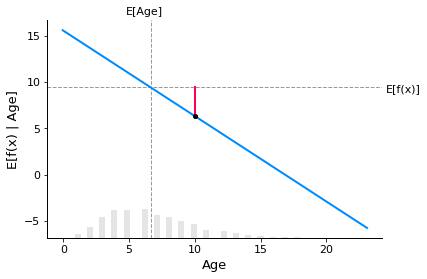

In [64]:
# построение стандартного графика частичной зависимости
sample_ind = 23
fig,ax = shap.partial_dependence_plot("Age", new_model.predict, xtrain, model_expected_value=True, 
                                      feature_expected_value=True, show=False, ice=False, 
                                      shap_values=shap_values[sample_ind:sample_ind+1,:])

Тесное соответствие между классическим графиком частичной зависимости и значениями SHAP означает, что если мы нанесем значение SHAP для определенного объекта по всему набору данных, мы точно проследим среднецентрированную версию графика частичной зависимости для этого объекта

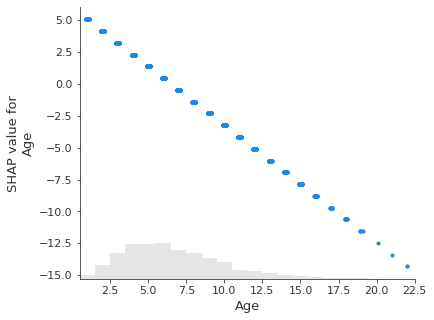

In [65]:
shap.plots.scatter(shap_values[:,"Age"])

Диаграмма водопада, показывающая положительные и отрицательные значения SHAP

In [85]:
new_model.predict(xtrain[60:61])

array([4.7269455])

In [86]:
ytrain[60:61]

2966    4.85
Name: Price, dtype: float64

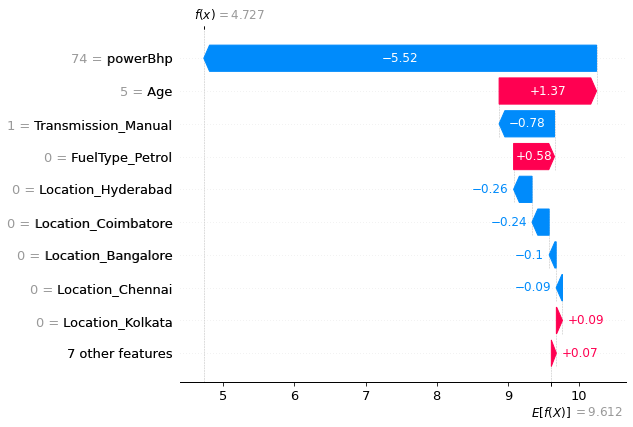

In [87]:
# диаграмма водопада показывает, как мы переходим от shap_values.base_values к model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[60])

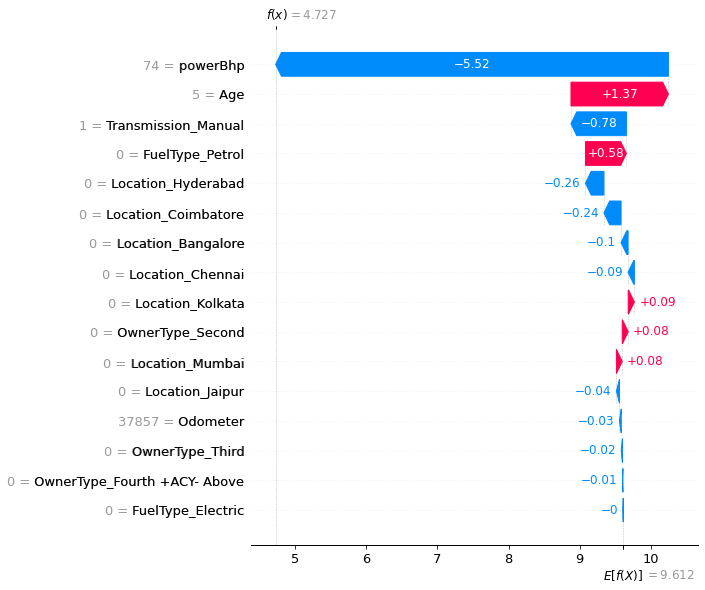

In [88]:
# без others на диаграмме
shap.plots.waterfall(shap_values[60],max_display=30)